# Part Segmentation of 3D Point Clouds with OpenVINO™  

This notebook demonstrates how to process [point cloud](https://en.wikipedia.org/wiki/Point_cloud) data and run 3D Part Segmentation with OpenVINO. We use the [PointNet](https://arxiv.org/abs/1612.00593) pre-trained model to detect each part of a chair and return its category.

## PointNet

PointNet was proposed by Charles Ruizhongtai Qi, a researcher at Stanford University in 2016: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593). The motivation behind the research is to classify and segment 3D representations of images. They use a data structure called point cloud, which is a set of points that represents a 3D shape or object. PointNet provides a unified architecture for applications ranging from object classification, part segmentation, to scene semantic parsing. It is highly efficient and effective, showing strong performance on par or even better than state of the art.

#### Table of content:- [Imports](#Imports-Uparrow)
- [Prepare the Model](#Prepare-the-Model-Uparrow)
- [Data Processing Module](#Data-Processing-Module-Uparrow)
- [Visualize the original 3D data](#Visualize-the-original-3D-data-Uparrow)
- [Run inference](#Run-inference-Uparrow)
    - [Select inference device](#Select-inference-device-Uparrow)


In [1]:
%pip install -q "openvino>=2023.1.0"

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\rohan\anaconda3\envs\openvino_env\python.exe -m pip install --upgrade pip' command.


## Imports [$\Uparrow$](#Table-of-content:)


In [2]:
from pathlib import Path
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import openvino as ov

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file

## Prepare the Model [$\Uparrow$](#Table-of-content:)
Download the pre-trained PointNet ONNX model. This pre-trained model is provided by [`axinc-ai`](https://github.com/axinc-ai), and you can find more point clouds examples [here](https://github.com/axinc-ai/ailia-models/tree/master/point_segmentation).

In [3]:
# Set the data and model directories, model source URL and model filename
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(exist_ok=True)
download_file("https://storage.googleapis.com/ailia-models/pointnet_pytorch/chair_100.onnx", directory=Path(MODEL_DIR), show_progress=False)
onnx_model_path = MODEL_DIR / "chair_100.onnx"

Convert the ONNX model to OpenVINO IR. An OpenVINO IR (Intermediate Representation) model consists of an `.xml` file, containing information about network topology, and a `.bin` file, containing the weights and biases binary data. Model conversion Python API is used for conversion of ONNX model to OpenVINO IR. The `ov.convert_model` Python function returns an OpenVINO model ready to load on a device and start making predictions. We can save it on a disk for next usage with `ov.save_model`. For more information about model conversion Python API, see this [page](https://docs.openvino.ai/2023.0/openvino_docs_model_processing_introduction.html).

In [4]:
ir_model_xml = onnx_model_path.with_suffix(".xml")

core = ov.Core()

if not ir_model_xml.exists():
    # Convert model to OpenVINO Model
    model = ov.convert_model(onnx_model_path)
    # Serialize model in OpenVINO IR format xml + bin
    ov.save_model(model, ir_model_xml)
else:
    # Read model
    model = core.read_model(model=ir_model_xml)
    

## Data Processing Module [$\Uparrow$](#Table-of-content:)


In [5]:
def load_data(point_file: Union[str, Path]):
    """
    Load the point cloud data and convert it to ndarray

    Parameters:
        point_file: string, path of .pts data
    Returns:
       point_set: point clound represented in np.array format
    """

    point_set = np.loadtxt(point_file).astype(np.float32)

    # normailization
    point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0)  # center
    dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
    point_set = point_set / dist  # scale

    return point_set


def visualize(point_set:np.ndarray):
    """
    Create a 3D view for data visualization

    Parameters:
        point_set: np.ndarray, the coordinate data in X Y Z format
    """

    fig = plt.figure(dpi=192, figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    X = point_set[:, 0]
    Y = point_set[:, 2]
    Z = point_set[:, 1]

    # Scale the view of each axis to adapt to the coordinate data distribution
    max_range = np.array([X.max() - X.min(), Y.max() - Y.min(), Z.max() - Z.min()]).max() * 0.5
    mid_x = (X.max() + X.min()) * 0.5
    mid_y = (Y.max() + Y.min()) * 0.5
    mid_z = (Z.max() + Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tick_params(labelsize=5)
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)

    return ax

## Visualize the original 3D data [$\Uparrow$](#Table-of-content:)
The point cloud data can be downloaded from [ShapeNet](https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip), a large-scale dataset of 3D shapes. Here, we select the 3D data of a chair for example.

data\chair.pts:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

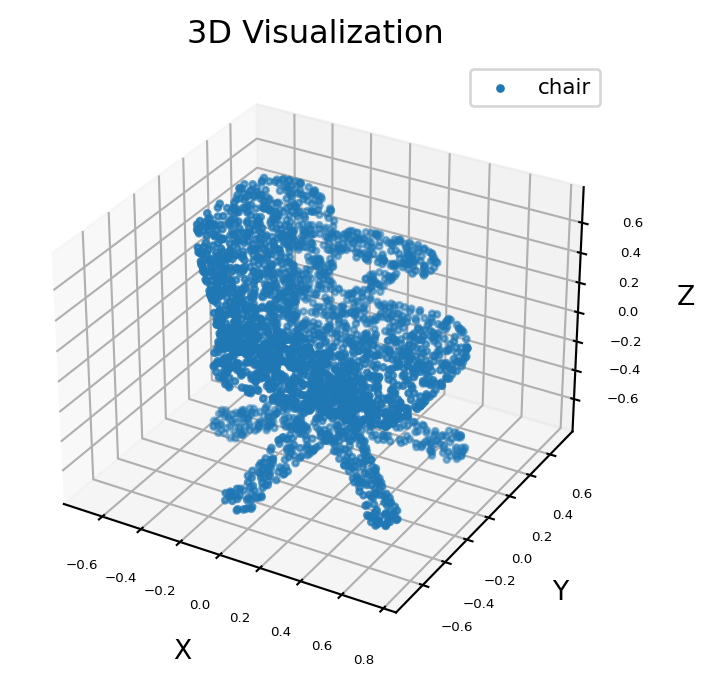

In [6]:
# Download data from the openvino_notebooks storage
point_data = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/pts/chair.pts",
    directory="data"
)

points = load_data(str(point_data))
X = points[:, 0]
Y = points[:, 2]
Z = points[:, 1]
ax = visualize(points)
ax.scatter3D(X, Y, Z, s=5, cmap="jet", marker="o", label='chair')
ax.set_title('3D Visualization')
plt.legend(loc='upper right', fontsize=8)
plt.show()

## Run inference [$\Uparrow$](#Table-of-content:)
Run inference and visualize the results of 3D segmentation.
- The input data is a point cloud with `1 batch size`，`3 axis value` (x, y, z) and `arbitrary number of points` (dynamic shape).
- The output data is a mask with `1 batch size` and `4 classification confidence` for each input point.

In [7]:
# Parts of a chair
classes = ['back', 'seat', 'leg', 'arm']

# Preprocess the input data
point = points.transpose(1, 0)
point = np.expand_dims(point, axis=0)

# Print info about model input and output shape
print(f"input shape: {model.input(0).partial_shape}")
print(f"output shape: {model.output(0).partial_shape}")

input shape: [1,3,?]
output shape: [1,?,4]


### Select inference device [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [ ]:
# Inference
compiled_model = core.compile_model(model=model, device_name=device.value)
output_layer = compiled_model.output(0)
result = compiled_model([point])[output_layer]

# Find the label map for all points of chair with highest confidence
pred = np.argmax(result[0], axis=1)
ax = visualize(point)
for i, name in enumerate([0, 1, 2, 3]):
    XCur = []
    YCur = []
    ZCur = []
    for j, nameCur in enumerate(pred):
        if name == nameCur:
            XCur.append(X[j])
            YCur.append(Y[j])
            ZCur.append(Z[j])
    XCur = np.array(XCur)
    YCur = np.array(YCur)
    ZCur = np.array(ZCur)

    # add current point of the part
    ax.scatter(XCur, YCur, ZCur, s=5, cmap="jet", marker="o", label=classes[i])

ax.set_title('3D Segmentation Visualization')
plt.legend(loc='upper right', fontsize=8)
plt.show()